In [1]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from evaluate import *

In [2]:
# exp_dict = {
#     'flux_reg_none': Path("../runs/flux_regularization/tft_20240715_220858"),
#     'flux_reg_0': Path("../runs/flux_regularization/tft_0_20240715_220838"),
# }

exp_dict = {
    'flux_reg_all_vars': Path("../runs/flux_regularization/tft_0_20240715_220838"),
    # 'all_vars': Path("../runs/flux_regularization/tft_20240715_220858"),
    'era5_only': Path("../runs/flux_regularization/tft_0_era5_20240717_172513"),
    'ablate': Path("../runs/flux_regularization/tft_0_era5_ablation_20240718_143621")
}

exp_dict = {
    'all_vars': Path("../runs/hybrid_feature_ablation/full_20240719_195923"),
    'era5_trim': Path("../runs/hybrid_feature_ablation/era5_trim_20240719_200434"),
    'optical_trim': Path("../runs/hybrid_feature_ablation/optical_trim_20240719_200537"),
    'trim_all': Path("../runs/hybrid_feature_ablation/trim_20240719_200421")
}
            

exp_names = []
results = []
bulk_metrics = []
basin_metrics = []
for exp_name, exp_dir in exp_dict.items():
    exp_names.append(exp_name)
    with open(exp_dir / "test_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        results.append(r)
        bulk_metrics.append(bulk_m)
        basin_metrics.append(basin_m)


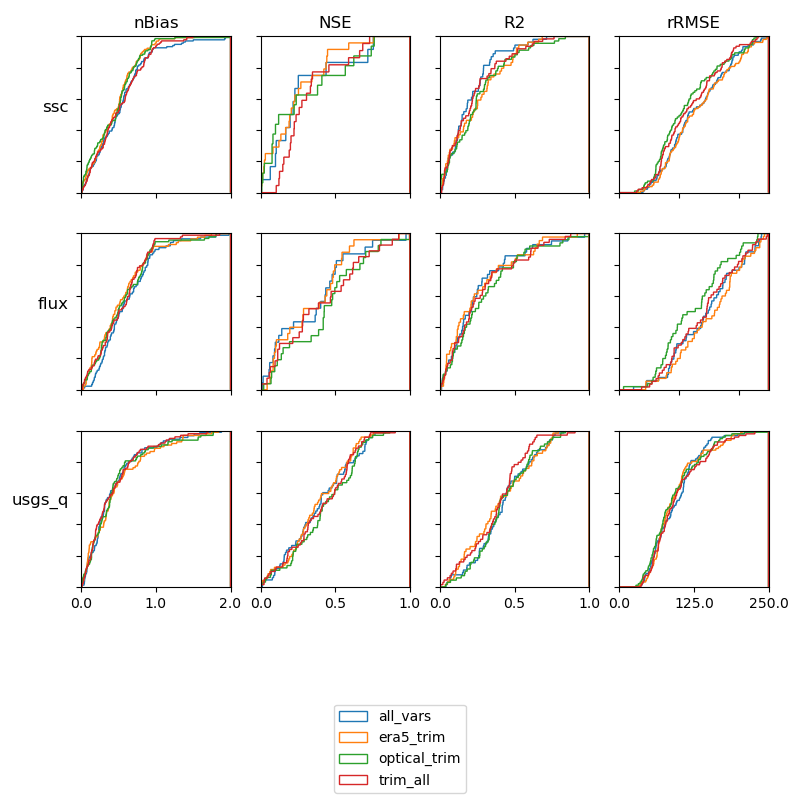

In [3]:
plt.close('all')

features = bulk_metrics[0].keys()

metric_args = {
    'nBias':{'range':[0,2]},
    'NSE':{'range':[0,1]},
    'R2':{'range':[0,1]},
    'rRMSE':{'range':[0,250]}}

common_args = {
    'bins': 1000,
    'cumulative': True, 
    'density': True,
    'histtype': 'step'
}
# common_args = {
#     'bins':20,
#     'alpha':0.5,
# }

features = ['ssc', 'flux', 'usgs_q']
nRows = len(features)+1 #Extra row for legend
nCols = len(metric_args)
fig, axes = plt.subplots(nRows, nCols, figsize=(2*nCols,2*nRows))

    
for feature, axes_row in zip(features, axes[:-1]):
    for (metric, metric_kwargs), ax in zip(metric_args.items(), axes_row):
        for m in basin_metrics:
            x = m[feature, metric].astype(float)
            x = x[np.isfinite(x)]
            
            if 'bias' in metric.lower():
                x = np.abs(x)
                
            ax.hist(x, **common_args, **metric_kwargs)
        
        ax.set_aspect(1./ax.get_data_ratio())
        ax.set_xlim(metric_kwargs['range'])
        ax.set_ylim([0,1])
        # ax.set_xticks([])
        # ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        
for (metric, _), ax in zip(metric_args.items(), axes[0,:]):
    ax.set_title(metric)
    
for feature, ax in zip(features, axes[:-1,0]):
    ax.set_ylabel(feature, rotation=0, ha='right', fontsize='large', labelpad=2)

for ax in axes[-2,:]:
    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3))
    ax.set_xticklabels(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3))

for ax in axes[-1,:]:
    ax.set_axis_off()
    
fig.legend(exp_names, loc='lower center')

fig.tight_layout()

In [6]:
from train import load_last_state
from data import TAPDataset, TAPDataLoader
from evaluate import predict

# basin = 'USGS-09367540'
# basin = 'USGS-06109500' #no flux but nice seasonality
basin = 'USGS-08332010' #Nice flux temporal distribution and seasonality


exp_preds = []
for exp_name, exp_dir in exp_dict.items():
    cfg, model, trainer_state, opt_state, _ = load_last_state(exp_dir)
    cfg['quiet'] = False
    cfg['data_subset'] = 'predict'
    cfg['basin_subset'] =  basin
    cfg['num_workers'] = 0 # Faster for small runs
    
    dataset = TAPDataset(cfg)
    dataloader = TAPDataLoader(cfg, dataset)
    preds = predict(model, dataloader, seed=0, denormalize=True, return_dt=True)
    preds['pred'] = preds['pred'] * (preds['pred']>0) #Clip preds to 0

    preds = preds.reset_index()
    preds = preds.sort_values(by='date')
    preds = preds.drop('basin', axis=1, level=0)
    preds.set_index('date', inplace=True)
    
    exp_preds.append(preds)

Loading model state from ../runs/tft/flux_only_4_head_064_365_20240703_142234/epoch050


2024-07-05 14:39:54.832406: W external/xla/xla/service/platform_util.cc:199] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 11546394624


RuntimeError: Unable to initialize backend 'cuda': INTERNAL: no supported devices found for platform CUDA (you may need to uninstall the failing plugin package, or set JAX_PLATFORMS=cpu to skip this backend.)

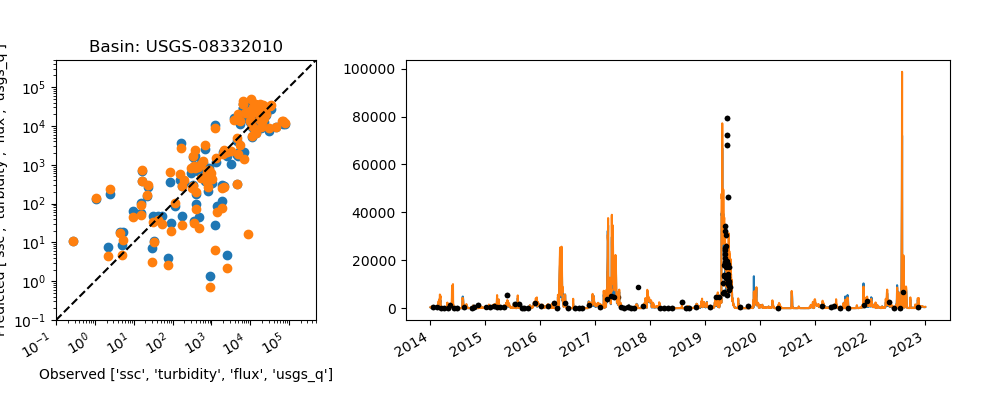

In [8]:
import matplotlib.gridspec as gridspec

# Plot the true values and predictions
plt.close('all')

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]


min_val = 1E-1
max_val = 5E5

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for preds, color in zip(exp_preds, colors):
    pred = preds['pred']['flux']
    obs = preds['obs']['flux']
    axes[0].scatter(obs, pred, color=color)

    axes[1].plot(pred, color=color)
    axes[1].plot(obs, linestyle='None',marker='.',color='k')

axes[0].plot([min_val, max_val], [min_val, max_val], 'k--')

# Setting axes to be square and equal range
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].axis('square')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed {cfg['features']['target']}")
axes[0].set_ylabel(f"Predicted {cfg['features']['target']}")
axes[0].set_title(f"Basin: {basin}")

# axes[1].set_ylim([0,40000])


fig.subplots_adjust(top=0.85, left=0.05, right=0.95, wspace=0.05, hspace=0.4)
# fig.suptitle(str(run_dir))
fig.autofmt_xdate()

plt.show()

# fig.savefig(run_dir / f"{basin}_timeseries.png",  dpi=300)

In [ ]:


colors